Задача:

🔸детектировать табличную часть справки и распознать  текст.

🔸Оценить качество этого решения на данных, предоставленных заказчиком. Метрика: acc

Этапы работы:
1. Выбор решения: поиск реппозитория или статьи и применение решения на данных (27.06 - 4.07)
2. Сравнение результатов с CSV данными - проверка качества проверки данных и улучшение качетсва (4.07 - 11.07)
3. Создание микросервиса  (11.07 - 18.07)

На справках нужно распознать:

✅ полная дата донации (число, месяц, год в формате дд.мм.
гггг)

✅ тип донации (платно или безвозмездно)

✅ вид донации (цельная кровь, плазма, тромбоциты,
эритроциты, гранулоциты (лейкоциты))

✅ центр крови

➕ Если получится, то город.

🔥Условные обозначения в справке🔥:

кр/д - кроводача (то есть цельная кровь)
пл/д - плазмадача (плазма) 
ц/д - цитосдача (тромбоциты)

БВ - это безвозмездно, а ПЛАТ - это платно.

- обработка:
    * изменить положение картинки, т.е. повернуть и увеличить изображение (OpenCV)
    * увеличить разрешение (torch)
    * размытие (нейросетью)
- 3 типа изображений: 8, 9, 4 колонок в таблице
- извлечение таблицы:
    * пометить области ячеек таблицы (координаты)
    * извлечь текст из каждой ячейки (pytesseract)

<h2>Детекция печати</h2>

In [22]:
import cv2
import numpy as np
import pandas as pd
import pytesseract
from glob import glob
import matplotlib.pyplot as plt

# pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

In [23]:
imgs = glob('../data/yandex/405/pic/*')

In [24]:
img = cv2.imread('../data/yandex/405/pic/236000 .jpg')

In [25]:
def imshow(img, showAxis = False, size=(20,10)):
    plt.figure(figsize=size)
    if not showAxis: plt.axis('off')
    if len(img.shape) == 3: plt.imshow(img[:,:,::-1])
    else: plt.imshow(img, cmap='gray')

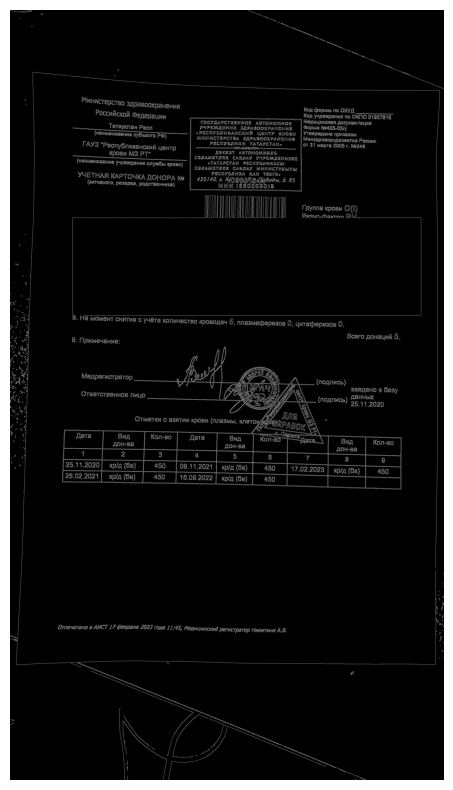

In [26]:
gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)

# Blur to remove noise
blur = cv2.bilateralFilter(gray.copy(), 15, 15, 15 )

# Find edges using canny edge detector
def auto_canny(grayim, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(grayim)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(grayim, lower, upper)
    # return the edged image
    return edged

# Find the edges and display the image
edged = auto_canny(blur)
imshow(edged)

In [27]:
# detect the contours on the binary image
contours, _ = cv2.findContours(image=edged.copy(), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
print(f'Total nr of contours found: {len(contours)}')

# Sort Contours by Area and get topN
topN = 10
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)                     
sorted_contours = sorted_contours[:topN]

Total nr of contours found: 1519


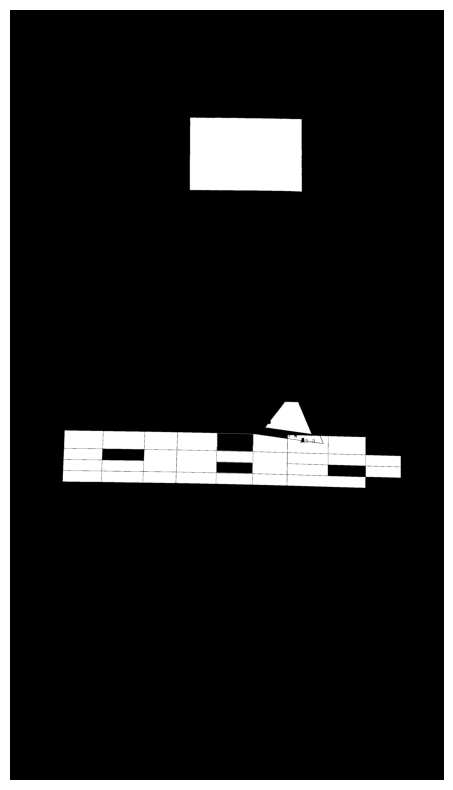

In [28]:
filteredCircle = np.zeros((img.shape[:2]), dtype =np.uint8)
cv2.drawContours(image=filteredCircle, contours=sorted_contours, contourIdx=-1, color=(255, 255, 255), thickness=cv2.FILLED)
imshow(filteredCircle)

<h2>Распознавание текста с помощью img2table</h2>

In [1]:
from img2table.document import Image
from img2table.ocr import TesseractOCR

In [4]:
src = '../data/yandex/405/pic/236000 .jpg'
image = Image(src, detect_rotation=True)

In [9]:
# Instantiation of OCR
ocr = TesseractOCR(n_threads=1, lang="rus")

# Instantiation of document, either an image or a PDF
doc = Image(src)

# Table extraction
extracted_tables = doc.extract_tables(ocr=ocr,
                                      implicit_rows=True,
                                      borderless_tables=True,
                                      min_confidence=50)

In [10]:
extracted_tables

[ExtractedTable(title=8. На момент снятия с учёта количество кроводач 5, плазмаферезов 0,
 цитаферезов 0.
 Всего донаций 5.
 9. Примечание:
 Л
 ЕЙ р
 Медрегистратор
 (подпись)
 введено в базу
 Ответственное лицо
 данных
 (подпись)
 25.11.2020
 7
 ДЛЯ
 СУ
 Отметки о взятии крови (плазмы, клето, bbox=(278, 2210, 2043, 2496),shape=(9, 7))]

<h2>Распознавание таблицы с помощью paddlepaddle</h2>

In [26]:
pip install paddlepaddle-gpu==2.4.2.post117 -f https://www.paddlepaddle.org.cn/whl/windows/mkl/avx/stable.html

Looking in links: https://www.paddlepaddle.org.cn/whl/windows/mkl/avx/stable.html
  Using cached https://paddle-wheel.bj.bcebos.com/2.4.2/windows/windows-gpu-cuda11.7-cudnn8.4.1-mkl-avx-vs2019/paddlepaddle_gpu-2.4.2.post117-cp39-cp39-win_amd64.whl (489.3 MB)
  Attempting uninstall: paddlepaddle-gpu
    Found existing installation: paddlepaddle-gpu 2.5.0
    Uninstalling paddlepaddle-gpu-2.5.0:
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'c:\\python3.9.13\\lib\\site-packages\\paddle\\fluid\\libpaddle.pyd'
Consider using the `--user` option or check the permissions.



In [ ]:
# pip install paddleocr --upgrade
# pip install paddlepaddle

In [7]:
import paddle

In [8]:
paddle.utils.run_check()

Running verify PaddlePaddle program ... 
PaddlePaddle works well on 1 CPU.
PaddlePaddle is installed successfully! Let's start deep learning with PaddlePaddle now.


In [5]:
# wget https://paddleocr.bj.bcebos.com/whl/layoutparser-0.0.0-py3-none-any.whl
# pip install -U layoutparser-0.0.0-py3-none-any.whl

Processing c:\users\1rati\jupyter\yandex_job\layoutparser-0.0.0-py3-none-any.whl


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\1rati\\Jupyter\\Yandex_job\\layoutparser-0.0.0-py3-none-any.whl'



In [43]:
from paddleocr import PaddleOCR,draw_ocr

In [9]:
import layoutparser as lp
import cv2

In [30]:
import matplotlib.pyplot as plt

In [37]:
# img_path = 'C:/Users/1rati/Jupyter/data/yandex/405/pic/236000 .jpg'
img_path = 'C:/Users/1rati/Jupyter/data/yandex/405/pic/254586 .jpg'
# img_path = 'C:/Users/1rati/Jupyter/data/yandex/405/pic/213950.jpg'
img = cv2.imread(img_path)

model = lp.PaddleDetectionLayoutModel(config_path='lp://PubLayNet/ppyolov2_r50vd_dcn_365e_publaynet/config',
                                      threshold=0.5,
                                      label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"},
                                      enforce_cpu=False,
                                      enable_mkldnn=True)

In [38]:
layout = model.detect(img)

In [39]:
layout

Layout(_blocks=[TextBlock(block=Rectangle(x_1=16.0074462890625, y_1=3.573486328125, x_2=658.5125122070312, y_2=976.4075927734375), text=None, id=None, type=Figure, parent=None, next=None, score=0.8569985032081604), TextBlock(block=Rectangle(x_1=61.987762451171875, y_1=593.549072265625, x_2=648.6646728515625, y_2=722.5091552734375), text=None, id=None, type=Table, parent=None, next=None, score=0.8311167359352112), TextBlock(block=Rectangle(x_1=181.26919555664062, y_1=565.7260131835938, x_2=442.2879333496094, y_2=581.9464721679688), text=None, id=None, type=Text, parent=None, next=None, score=0.5499403476715088)], page_data={})

In [40]:
for l in layout:
    if l.type == 'Table':
        x_1 = int(l.block.x_1)
        x_2 = int(l.block.x_2)
        y_1 = int(l.block.y_1)
        y_2 = int(l.block.y_2)

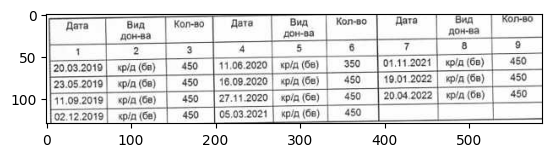

In [41]:
plt.imshow(img[y_1:y_2, x_1:x_2])

In [52]:
path = '../data/yandex/405/1.jpg'
cv2.imwrite(path, img[y_1:y_2, x_1:x_2])

True

In [60]:
ocr = PaddleOCR(use_angle_cls=True, lang='ru') # need to run only once to download and load model into memory
# img_path = '../data/yandex/405/pic/236000 .jpg'
result = ocr.ocr(path, cls=True)

[2023/07/11 14:18:54] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\1rati/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\1rati/.paddleocr/whl\\rec\\cyrillic\\cyrillic_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, 

In [77]:
boxes = [line[0] for line in result[0]]
texts = [line[1][0] for line in result[0]]
probs = [line[1][1] for line in result[0]]
for text in texts:
    print(text)

ета
Еид
нiе
Еид
на
Eн
пh
дHe
ргд
ер
дг
е
д
HE
д
E.
гд
еe
E
ргд
Tв
Tihge.
це
хрд
чэ
.н
гд
е
рд
He
е
DEge.
е


<h4>Вывод: русские буквы плохо распознаются. Нужно тренировать нейросеть</h4>

<h2>Выпрямление страницы с помощью page_dewarp</h2>

In [81]:
from page_dewarp import image
from page_dewarp.pdf import save_pdf
from page_dewarp.options import cfg

In [82]:
path = 'C:/Users/1rati/Jupyter/data/yandex/405/pic/141899 .jpg'
outfiles = []
processed_img  = image.WarpedImage(path)
if processed_img.written:
    outfiles.append(processed_img.outfile)
    print(f"  wrote {processed_img.outfile}", end="\n\n")

if cfg.pdf_opts.CONVERT_TO_PDF:
    save_pdf(outfiles)



Loaded 141899 .jpg at size='685x1000' --> resized='342x500'
  got 23 spans with 104 points.
  initial objective is 0.00451534504846275
  optimizing 135 parameters...
  optimization took 1.28 sec.
  final objective is 0.0029787985973783603
  got page dims 0.9993459088203808 x 1.87929327745737
  output will be 512x944
  wrote 141899 _thresh.png



In [84]:
im = cv2.imread('../Yandex_job/141899 _thresh.png')

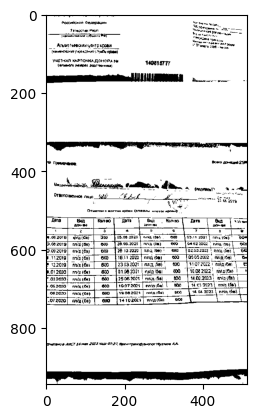

In [85]:
plt.imshow(im)

<h2>Вывод: качество ухудшилось, страница не выровнена</h2>